In [1]:
#Installing the Chemsitry and the Quantum packages
!pip install pyscf
!pip install qiskit

     |████████████████████████████████| 29.5MB 144kB/s 
     |████████████████████████████████| 8.5MB 3.5MB/s 
     |████████████████████████████████| 17.6MB 255kB/s 
     |████████████████████████████████| 204kB 48.4MB/s 
     |████████████████████████████████| 204kB 45.8MB/s 
     |████████████████████████████████| 2.1MB 45.6MB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 1.0MB 39.9MB/s 
     |████████████████████████████████| 194kB 34.6MB/s 
     |████████████████████████████████| 81kB 8.3MB/s 
     |████████████████████████████████| 583kB 30.2MB/s 
     |████████████████████████████████| 3.2MB 45.9MB/s 
     |████████████████████████████████| 5.5MB 49.5MB/s 
  Created wheel for qiskit: filename=qiskit-0.24.0-cp37-none-any.whl size=2918 sha256=941f87c22600dcf8a1531a81bcec87859204be5b1a684c5dadfc9df0203845fb
  Stored in directory: /root/.cache/pip/wheels/22/fe/0a/26b7a409d1a9c3698b0319c7d009a97bffaae392d755158dca
  Created wheel for

In [4]:
#importing tons of packages
import numpy as np #To make a nice little distance list
import pylab #to plot things
import copy #It's used in running of the circuit
from qiskit import BasicAer #Simulator
from qiskit.aqua import aqua_globals, QuantumInstance #It's used in running of the circuit
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE #The classical solution finder and the quatnum solution finder
from qiskit.aqua.components.optimizers import SLSQP #Optimizer for the parameters of the ansatz 
from qiskit.chemistry.components.initial_states import HartreeFock #This is gonna be the initial Ansatz, and it's the current energy estimation for molecules 
from qiskit.chemistry.components.variational_forms import UCCSD #This acutally initalizes the ansatz
from qiskit.chemistry.drivers import PySCFDriver #Kinda simulates the molecules (then it's turned into a Hamiltonian)
from qiskit.chemistry.core import Hamiltonian, QubitMappingType #Takes our molecules and turns it into a matrix (Hamiltonian)

In [9]:
#Defining our molecules - HCl - with it's starting posiitons and which axis we can orientate
molecule = 'H .0 .0 -{0}; Cl .0 .0 {0}' 
#Makes a list of all the distances we'll be testing. From 0.5 to 4 with a step of 0.2
distances = np.arange(0.5, 4.0, 0.2)

In [10]:
#Making these lists so we can store their values and plot em afterwards
vqe_energies = [] #AKA the predicted energy
hf_energies = [] #AKA the intial predicted energy
exact_energies = [] #AKA the real life energy

In [25]:
def run_system():
  #At each distance in the distance list, we're going to run our simulations and get predictions + results
  for i,d in enumerate(distances):
    #Set up the experiment by simulating our molecule and then transforming it to the Hamiltonian Matrix (we gotta do it each time since the distances between the molecules are changing)

    #"Simulate" the molecule with the proper distance
    driver = PySCFDriver(molecule.format(d/2))
    #Then run it such that we can turn it into a hamiltonian
    qmol = driver.run()
    #Turn it into a Hamiltonian
    operator = Hamiltonian(freeze_core = True, orbital_reduction=[-3,-2])
    #Returns 2 operators. One is your standard Hamiltonian one. The other one is Hamiltonian one with auxilariery fields (Faster/more accurate I think)
    qubit_op, aux_op = operator.run(qmol)

    #Get the real life energy level through regular classical computation

    #Finds the minimum eigenvector
    exact_result = NumPyMinimumEigensolver(qubit_op, aux_op).run()
    #Computers the properties of the ground state energy. It's a class, so we can extract the energy by doing .energy
    exact_result = operator.process_algorithm_result(exact_result)
    

    #VQE time!
    #Set up the optimizer for finding the ansatz, set the maximum amount of iterations before convergence to 1000
    optimizer = SLSQP(1000)
    #Sets up the initial guess
    initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
                                operator.molecule_info['num_particles'],
                                operator._qubit_mapping,
                                operator._two_qubit_reduction)
    
    #Sets up the Ansatz
    ansatz = UCCSD(operator.molecule_info['num_orbitals'],
                  operator.molecule_info['num_particles'],
                  initial_state = initial_state,
                  qubit_mapping = operator._qubit_mapping,
                  two_qubit_reduction = operator._two_qubit_reduction)
    
    #The algorithm!!!
    Vqe = VQE(qubit_op, ansatz, optimizer, aux_operators=aux_op)

    #Run it and find the minimum eigenvector
    vqe_result = Vqe.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
    #same as before. finds the properties of the predicted groung state
    vqe_result = operator.process_algorithm_result(vqe_result)
    
    #Adding stuff to our lists
    exact_energies.append(exact_result.energy)
    vqe_energies.append(vqe_result.energy)
    hf_energies.append(vqe_result.hartree_fock_energy)

    print('step', i, "Exact energy: ", exact_energies[-1], "\n Predicted energy: ", vqe_energies[-1], "\n Initial energy: ", hf_energies[-1]) #So I know it's going well + readouts cause I'm curious

In [26]:
def plot_system():
  #Plotting everything
  pylab.plot(distances,hf_energies, label='Intial')
  pylab.plot(distances, vqe_energies, label='VQE')
  pylab.plot(distances, exact_energies, label='Exact')

  pylab.xlabel('Interatomic Distance')
  pylab.ylabel('Energy')
  pylab.title('HCl Ground State Energy')
  pylab.legend()

In [30]:
distances = np.arange(0.5, 4.0, 0.2)
#Reset it
vqe_energies = [] #AKA the predicted energy
hf_energies = [] #AKA the intial predicted energy
exact_energies = [] #AKA the real life energy

In [31]:
run_system()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The Hamiltonian class is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.

step 0 Exact energy:  -452.6056666519042 
 Predicted energy:  -452.60566642393746 
 Initial energy:  -452.6001781553993


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 1 Exact energy:  -454.2504880452825 
 Predicted energy:  -454.25048780130834 
 Initial energy:  -454.24330238066284


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 2 Exact energy:  -454.87744518048777 
 Predicted energy:  -454.8774451201346 
 Initial energy:  -454.8680261315971


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 3 Exact energy:  -455.10020448335354 
 Predicted energy:  -455.10020446238235 
 Initial energy:  -455.0869730231251


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 4 Exact energy:  -455.15530886935676 
 Predicted energy:  -455.1553088686001 
 Initial energy:  -455.1358748658519


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 5 Exact energy:  -455.14499958002426 
 Predicted energy:  -455.14499948686654 
 Initial energy:  -455.1161979067035


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 6 Exact energy:  -455.1133710791193 
 Predicted energy:  -455.1133710676502 
 Initial energy:  -455.07118413304215


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 7 Exact energy:  -455.0796590733859 
 Predicted energy:  -455.0796590496238 
 Initial energy:  -455.01940338458877


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 8 Exact energy:  -455.05207930358387 
 Predicted energy:  -455.0520792950277 
 Initial energy:  -454.96915455798495


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 9 Exact energy:  -454.92583473003015 
 Predicted energy:  -454.92583472638887 
 Initial energy:  -454.9242348399227


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 10 Exact energy:  -454.88766663259617 
 Predicted energy:  -454.8876665614957 
 Initial energy:  -454.8860935917081


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 11 Exact energy:  -454.8563600127032 
 Predicted energy:  -454.85635995437946 
 Initial energy:  -454.8548082569848


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 12 Exact energy:  -454.8323675646714 
 Predicted energy:  -454.8312710844219 
 Initial energy:  -454.82973654125067


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 13 Exact energy:  -454.99755625203335 
 Predicted energy:  -454.9971704083215 
 Initial energy:  -454.34965376235334


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 14 Exact energy:  -455.00842705081254 
 Predicted energy:  -454.64122286257617 
 Initial energy:  -454.64109664520834


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 15 Exact energy:  -455.0077133552579 
 Predicted energy:  -454.632150898184 
 Initial energy:  -454.6320702162401


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 16 Exact energy:  -455.008574685569 
 Predicted energy:  -454.62353385853027 
 Initial energy:  -454.6235054056036


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 17 Exact energy:  -455.00859451064423 
 Predicted energy:  -455.00859187266497 
 Initial energy:  -454.61615952432754


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()


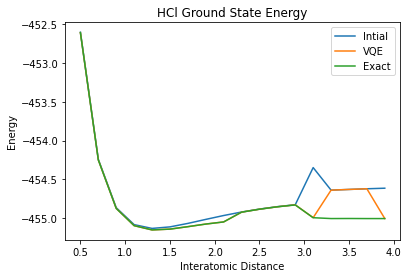

In [32]:
plot_system()

In [33]:
molecule = 'H .0 .0 -{0}; Cl .0 .0 {0}' 

distances = np.arange(0.5, 4.0, 0.05)

#Reset it
vqe_energies = [] #AKA the predicted energy
hf_energies = [] #AKA the intial predicted energy
exact_energies = [] #AKA the real life energy

In [34]:
run_system()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The Hamiltonian class is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.

step 0 Exact energy:  -452.6056666519042 
 Predicted energy:  -452.60566642393746 
 Initial energy:  -452.6001781553993


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 1 Exact energy:  -453.1855816561515 
 Predicted energy:  -453.1855814759468 
 Initial energy:  -453.1797233028885


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 2 Exact energy:  -453.63004068002556 
 Predicted energy:  -453.63004049771416 
 Initial energy:  -453.62375904336426


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 3 Exact energy:  -453.9768461276194 
 Predicted energy:  -453.97684591572266 
 Initial energy:  -453.97011653045615


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 4 Exact energy:  -454.2504880452825 
 Predicted energy:  -454.25048780126434 
 Initial energy:  -454.24330238066256


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 5 Exact energy:  -454.46710780653734 
 Predicted energy:  -454.4671075413659 
 Initial energy:  -454.459448458582


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 6 Exact energy:  -454.63821219563897 
 Predicted energy:  -454.6382119217723 
 Initial energy:  -454.6300384356598


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 7 Exact energy:  -454.7726366721959 
 Predicted energy:  -454.77263639952844 
 Initial energy:  -454.76388325606234


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 8 Exact energy:  -454.87744518048794 
 Predicted energy:  -454.8774451200747 
 Initial energy:  -454.86802613159756


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 9 Exact energy:  -454.9583674046064 
 Predicted energy:  -454.95836735385353 
 Initial energy:  -454.94818030126186


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 10 Exact energy:  -455.02006301391447 
 Predicted energy:  -455.0200629734399 
 Initial energy:  -455.00899209367685


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 11 Exact energy:  -455.06631799065957 
 Predicted energy:  -455.06631796037107 
 Initial energy:  -455.0542359063263


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 12 Exact energy:  -455.10020448335354 
 Predicted energy:  -455.1002044624071 
 Initial energy:  -455.0869730231253


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 13 Exact energy:  -455.1242131619856 
 Predicted energy:  -455.1242131489526 
 Initial energy:  -455.1096832899428


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 14 Exact energy:  -455.14036215951666 
 Predicted energy:  -455.1403621525314 
 Initial energy:  -455.124373656957


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 15 Exact energy:  -455.1502861368501 
 Predicted energy:  -455.1502861339257 
 Initial energy:  -455.1326670438491


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 16 Exact energy:  -455.15530886935693 
 Predicted energy:  -455.1553088685935 
 Initial energy:  -455.1358748658519


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 17 Exact energy:  -455.1565023547955 
 Predicted energy:  -455.1565020168528 
 Initial energy:  -455.13505617965944


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 18 Exact energy:  -455.1547349223026 
 Predicted energy:  -455.1547346854638 
 Initial energy:  -455.1310659026976


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 19 Exact energy:  -455.15071034537175 
 Predicted energy:  -455.1507101903654 
 Initial energy:  -455.1245940931633


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 20 Exact energy:  -455.14499958002415 
 Predicted energy:  -455.1449994867219 
 Initial energy:  -455.1161979067037


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 21 Exact energy:  -455.1380664507033 
 Predicted energy:  -455.13806631844363 
 Initial energy:  -455.10632755540837


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 22 Exact energy:  -455.13028836123794 
 Predicted energy:  -455.13028826198104 
 Initial energy:  -455.0953473585093


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 23 Exact energy:  -455.1219729049205 
 Predicted energy:  -455.121972834012 
 Initial energy:  -455.0835527742131


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 24 Exact energy:  -455.1133710791196 
 Predicted energy:  -455.11337106764324 
 Initial energy:  -455.07118413304244


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 25 Exact energy:  -455.10468767928575 
 Predicted energy:  -455.10468766673216 
 Initial energy:  -455.0584376547144


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 26 Exact energy:  -455.0960893537945 
 Predicted energy:  -455.0960893266519 
 Initial energy:  -455.04547422261874


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 27 Exact energy:  -455.08771074084876 
 Predicted energy:  -455.08771071578286 
 Initial energy:  -455.032426309028


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 28 Exact energy:  -455.0796590733862 
 Predicted energy:  -455.0796590494901 
 Initial energy:  -455.01940338458894


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 29 Exact energy:  -455.0720176165489 
 Predicted energy:  -455.07201759405484 
 Initial energy:  -455.0064961006134


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 30 Exact energy:  -455.06484828299824 
 Predicted energy:  -455.06484826374697 
 Initial energy:  -454.99377949612193


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 31 Exact energy:  -455.0581937432412 
 Predicted energy:  -455.0581937294517 
 Initial energy:  -454.98131544886667


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 32 Exact energy:  -455.0520793035841 
 Predicted energy:  -455.0520792950016 
 Initial energy:  -454.9691545579845


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 33 Exact energy:  -455.0465147608173 
 Predicted energy:  -455.04651475525645 
 Initial energy:  -454.957337614511


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 34 Exact energy:  -454.94751327025494 
 Predicted energy:  -454.9475132659482 
 Initial energy:  -454.94589678491815


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 35 Exact energy:  -454.9364644526661 
 Predicted energy:  -454.93646444872826 
 Initial energy:  -454.9348566032012


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 36 Exact energy:  -454.92583473003026 
 Predicted energy:  -454.9258347264253 
 Initial energy:  -454.9242348399231


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 37 Exact energy:  -454.91563579789056 
 Predicted energy:  -454.91563530920337 
 Initial energy:  -454.91404329326434


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 38 Exact energy:  -454.90587413762034 
 Predicted energy:  -454.90587384819867 
 Initial energy:  -454.9042885281331


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 39 Exact energy:  -454.89655171710285 
 Predicted energy:  -454.89655156235403 
 Initial energy:  -454.8949725751603


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 40 Exact energy:  -454.8876666325963 
 Predicted energy:  -454.88766656169014 
 Initial energy:  -454.8860935917081


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 41 Exact energy:  -454.87921375953374 
 Predicted energy:  -454.879213731682 
 Initial energy:  -454.87764648137255


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 42 Exact energy:  -454.8711852880062 
 Predicted energy:  -454.87118527178427 
 Initial energy:  -454.86962346612574


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 43 Exact energy:  -454.86357125826225 
 Predicted energy:  -454.8635712298274 
 Initial energy:  -454.8620146052656


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 44 Exact energy:  -454.8563600127034 
 Predicted energy:  -454.8563599542261 
 Initial energy:  -454.8548082569854


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 45 Exact energy:  -454.84953860560876 
 Predicted energy:  -454.8495385045716 
 Initial energy:  -454.8479914807736


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 46 Exact energy:  -454.8430931329111 
 Predicted energy:  -454.84309298055666 
 Initial energy:  -454.84155038143024


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 47 Exact energy:  -454.8370090354409 
 Predicted energy:  -454.83700882660884 
 Initial energy:  -454.8354703978165


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 48 Exact energy:  -454.83236756656487 
 Predicted energy:  -454.8312710845693 
 Initial energy:  -454.8297365412505


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 49 Exact energy:  -455.0048559575471 
 Predicted energy:  -454.66275722504906 
 Initial energy:  -454.6621995888239


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 50 Exact energy:  -454.8273211158227 
 Predicted energy:  -454.82077363216246 
 Initial energy:  -454.81924624364956


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 51 Exact energy:  -454.8249388772048 
 Predicted energy:  -454.81598362675777 
 Initial energy:  -454.8144592529894


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 52 Exact energy:  -455.0101697752051 
 Predicted energy:  -454.8718665050836 
 Initial energy:  -454.65411312868633


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 53 Exact energy:  -455.0095328056109 
 Predicted energy:  -454.8543503867807 
 Initial energy:  -454.64939492861316


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 54 Exact energy:  -454.4867008134295 
 Predicted energy:  -454.43539296977406 
 Initial energy:  -454.4058967977787


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 55 Exact energy:  -455.00838247996927 
 Predicted energy:  -454.6437807145514 
 Initial energy:  -454.64363036454057


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 56 Exact energy:  -455.0084270508105 
 Predicted energy:  -454.6412228625739 
 Initial energy:  -454.64109664520566


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 57 Exact energy:  -455.0084523127071 
 Predicted energy:  -455.0084239544398 
 Initial energy:  -454.63909197816133


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 58 Exact energy:  -455.00916222705723 
 Predicted energy:  -454.84533150468394 
 Initial energy:  -454.636936028912


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 59 Exact energy:  -455.0089789115055 
 Predicted energy:  -454.8373765634913 
 Initial energy:  -454.6340736859371


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 60 Exact energy:  -455.0085342560721 
 Predicted energy:  -454.6318217282585 
 Initial energy:  -454.6317605295281


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 61 Exact energy:  -455.00853909082224 
 Predicted energy:  -454.6296711988819 
 Initial energy:  -454.62962040227745


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 62 Exact energy:  -455.00809259919265 
 Predicted energy:  -454.83156999236877 
 Initial energy:  -454.62847685574644


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 63 Exact energy:  -455.0086379543284 
 Predicted energy:  -454.6258113134393 
 Initial energy:  -454.6257709642134


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 64 Exact energy:  -454.8200576417535 
 Predicted energy:  -454.7883934251133 
 Initial energy:  -454.76408507938436


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 65 Exact energy:  -455.008512074111 
 Predicted energy:  -455.0085065078606 
 Initial energy:  -454.32435313734254


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 66 Exact energy:  -455.00858902842054 
 Predicted energy:  -454.61973992720345 
 Initial energy:  -454.6197207135579


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 67 Exact energy:  -454.96485143568555 
 Predicted energy:  -454.82372385979664 
 Initial energy:  -454.67089278642675


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 68 Exact energy:  -455.0086253641127 
 Predicted energy:  -455.0086218540923 
 Initial energy:  -454.3193989427812


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 69 Exact energy:  -455.008672620701 
 Predicted energy:  -454.3314474124764 
 Initial energy:  -454.31778670751703


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()


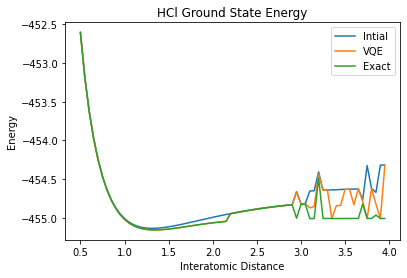

In [35]:
plot_system()

In [ ]:
#It's pretty cool that our VQE is super accruate for basically all of em! Now I'm going to try other molecules

In [40]:
#Just have to redefine my naming scheme
def plot_system():
  #Plotting everything
  pylab.plot(distances,hf_energies, label='Intial')
  pylab.plot(distances, vqe_energies, label='VQE')
  pylab.plot(distances, exact_energies, label='Exact')

  pylab.xlabel('Interatomic Distance')
  pylab.ylabel('Energy')
  pylab.title(name + 'Ground State Energy')
  pylab.legend()

In [37]:
molecule = 'Li .0 .0 -{0}; H .0 .0 {0}' 

distances = np.arange(0.5, 4.0, 0.2)

#Reset it
vqe_energies = [] #AKA the predicted energy
hf_energies = [] #AKA the intial predicted energy
exact_energies = [] #AKA the real life energy

name = "LiH"

In [38]:
run_system()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The Hamiltonian class is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.

step 0 Exact energy:  -7.039732521635198 
 Predicted energy:  -7.03973239274899 
 Initial energy:  -7.028410094541938


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 1 Exact energy:  -7.500922090905938 
 Predicted energy:  -7.500922059250943 
 Initial energy:  -7.485944870547275


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 2 Exact energy:  -7.72081241213478 
 Predicted energy:  -7.720812397405936 
 Initial energy:  -7.7057533401361145


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 3 Exact energy:  -7.823599276362815 
 Predicted energy:  -7.8235992700769295 
 Initial energy:  -7.808743176493419


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 4 Exact energy:  -7.867563290110054 
 Predicted energy:  -7.867563283312126 
 Initial energy:  -7.851953857956239


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 5 Exact energy:  -7.8810157156469955 
 Predicted energy:  -7.881015701732135 
 Initial energy:  -7.8633576215351155


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.

step 6 Exact energy:  -7.8782681675849915 
 Predicted energy:  -7.878268153862454 
 Initial energy:  -7.857144960203829


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 7 Exact energy:  -7.867233964816032 
 Predicted energy:  -7.867233666727055 
 Initial energy:  -7.841112040771401


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 8 Exact energy:  -7.852595827876733 
 Predicted energy:  -7.852595807319831 
 Initial energy:  -7.8197702577777175


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 9 Exact energy:  -7.837257967615502 
 Predicted energy:  -7.83725795319695 
 Initial energy:  -7.7958044838176335


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 10 Exact energy:  -7.823076642134088 
 Predicted energy:  -7.82307636313283 
 Initial energy:  -7.770873669221905


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 11 Exact energy:  -7.811168284803365 
 Predicted energy:  -7.811168248040415 
 Initial energy:  -7.7460797073609875


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 12 Exact energy:  -7.801973602332552 
 Predicted energy:  -7.801973365411554 
 Initial energy:  -7.722218783149364


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 13 Exact energy:  -7.795340451637529 
 Predicted energy:  -7.795340144574645 
 Initial energy:  -7.699880932787492


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 14 Exact energy:  -7.7907740099710105 
 Predicted energy:  -7.790773626634231 
 Initial energy:  -7.679468985510042


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 15 Exact energy:  -7.787716973466144 
 Predicted energy:  -7.787716828173505 
 Initial energy:  -7.66120160151523


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:91: DeprecationWarning: The ChemistryOperator is deprecated as of Qiskit Aqua 0.8.0 and will be removed no earlier than 3 months after the release date. Instead, the FermionicTransformation can be used to transform QMolecules and construct ground state result objects.
  super().__init__()
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 

step 16 Exact energy:  -7.785702912499899 
 Predicted energy:  -7.785702790795292 
 Initial energy:  -7.6451334668130935


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()


step 17 Exact energy:  -7.784389611671414 
 Predicted energy:  -7.784389483732119 
 Initial energy:  -7.631193460706963


/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/chemistry_operator.py:170: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularChemistryResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  super().__init__(a_dict)
/usr/local/lib/python3.7/dist-packages/qiskit/chemistry/core/hamiltonian.py:380: DeprecationWarning: The qiskit.chemistry.chemistry_operator.MolecularGroundStateResult object is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use qiskit.chemistry.algorithms.ground_state_solvers.FermionicGroundStateResult instead.
  mgsr = MolecularGroundStateResult()


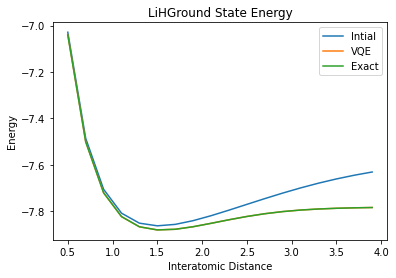

In [41]:
plot_system()

In [54]:
#That was spot on!